---
**Numerical continuation**

Week 17 of EMAT30008

https://engmaths.github.io/emat30008/odes/numericalcontinuation/

(See scicomp/odefunctions.py for associated functions)

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scicomp.odefunctions import *
from scipy.optimize import root

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


----------
We start by prototyping code for natural parameter continuation

We first conduct a single step of natural parameter continuation in the following cell:

In [2]:
# Define a basic polynomial with a parameter c
def polynomial(x,c):
    return x**3 -x + c

# Write out first step by hand
deltac = 0.1
c0 = -1

# Freeze the polynomial with c=c0, 
# Use root finding with an initial guess to find the corresponding root
xpolynomial = lambda x: polynomial(x, c=c0)
x0guess = 1
x0 = root(xpolynomial, x0guess).x
print("x_0 =", x0)

# Update the parameter c, and use the last solution as our initial guess
c1 = c0 + deltac
xpolynomial = lambda x: polynomial(x, c=c1)
x1 = root(xpolynomial, x0).x
print("x_1 =",x1)

x_0 = [1.32471796]
x_1 = [1.30073658]


We now conduct multiple steps of natural parameter continuation and plot the result

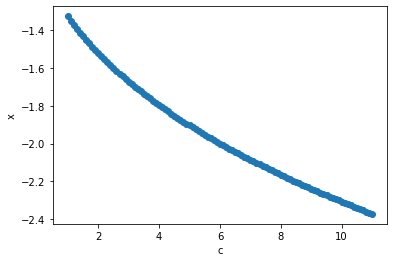

In [3]:
# Define basic polynomial
def polynomial(x,c):
    return x**3 -x + c

# Write out first step by hand
c0 = 1
deltac = 0.1
x0guess = -5
xpolynomial = lambda x: polynomial(x, c=c0)
x0 = root(xpolynomial, x0guess).x

# Define a basic step function
def natural_param_step(xi, ci):
    c_next = ci + deltac
    xpolynomial = lambda x: polynomial(x, c=c_next)
    x_next = root(xpolynomial, xi).x
    return x_next, c_next

# Do some steps
x_store = [x0]
c_store = [c0]

x = x0
c = c0
for i in range(100):
    x, c = natural_param_step(x, c)
    x_store += [x]
    c_store += [c]

# Plot
plt.scatter(c_store, x_store)
plt.xlabel("c")
plt.ylabel("x")
plt.show()

This shows a very basic natural parameter continuation for the polynomial $x^3 -x + c$. 
Note if we change `x0guess` above we get a different plot.

We now do the same but for pseudo-arclength continuation.

------------
Pseudo-arclength continuation


[[ 1.         -1.32471796]
 [ 1.1        -1.34767277]
 [ 1.20020117 -1.36975121]
 [ 1.30057788 -1.39103297]
 [ 1.40110893 -1.41158678]
 [ 1.50177659 -1.43147239]
 [ 1.60256592 -1.45074207]
 [ 1.70346421 -1.46944185]
 [ 1.80446057 -1.48761251]
 [ 1.90554559 -1.50529035]
 [ 2.00671112 -1.52250783]
 [ 2.10795003 -1.53929413]]


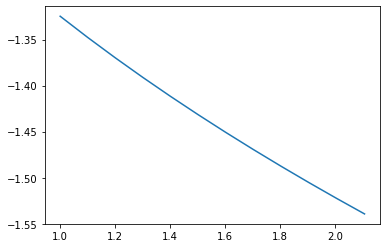

In [4]:
# Redefine polynomial in question, we set x to be an array for future generalisation
def polynomial(c: float, x: np.ndarray):
    return x[0]**3 - x[0] + c

# Start with c0 and an x_0 guess, find x_0
c0, x0guess = 1, np.array(([-5]))
fixed_poly = lambda x: polynomial(c=c0,x=x)
x0 = root(fixed_poly, x0guess).x

# Conduct a single step of natural parameter continuation to obtain x_1
deltac = 0.1
c1 = c0 + deltac
fixed_poly = lambda x: polynomial(c=c1,x=x)
x1guess = x0
x1 = root(fixed_poly, x1guess).x

# Construct v0 and v1 vectors
v0 = np.concatenate(([c0],x0))
v1 = np.concatenate(([c1],x1))

# Initialise stores for looping
v_store = np.stack((v0, v1))
v_last = v0
v_current = v1
num_steps = 10

# Define objective function used for root finding in each step
def psa_objective(v: np.ndarray, v_next_guess: np.ndarray, secant: np.ndarray):
    original = polynomial(c=v[0], x=v[1:])
    pseudo_arclength_eq = np.dot((v - v_next_guess),secant)
    return np.array(([original, pseudo_arclength_eq]))

# Conduct num_steps many steps of pseudo-arclength continuation
for i in range(num_steps):
    # Calculate secant and next guess
    secant = v_current - v_last
    v_next_guess = v_current + secant

    # Define current objective function and find its root for v_next
    current_objective = lambda v: psa_objective(v, v_next_guess, secant)
    v_next = root(current_objective, v_next_guess).x

    # Update
    v_store = np.vstack((v_store, v_next))
    v_last = v_current
    v_current = v_next

# Print and plot our final store
print(v_store)
plt.plot(v_store[:,0], v_store[:,1])
plt.show()

-------
We now write functions for both to generalise the methods, still specific to this ode function. After this we will develop code to take limit cycle or equillibrium points as our objectives.

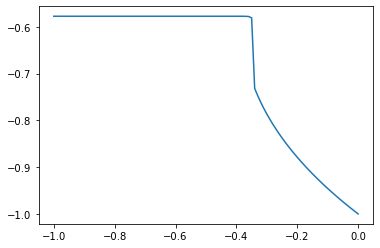

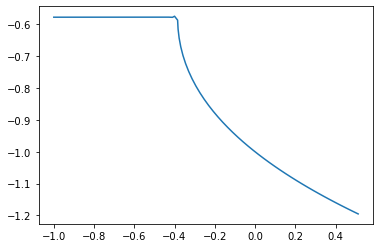

In [5]:
def numerical_continuation_polynomial(polynomial, c0, delta_c, x0guess, num_steps, method):
    
    # Fix parameter in polynomial function
    fixed_poly = lambda x: polynomial(c=c0,x=x)

    # Find x0, here by root finding on objective fixed_poly
    x0 = root(fixed_poly, x0guess).x

    # Update c by delta_c, do the same thing
    c1 = c0 + delta_c
    fixed_poly = lambda x: polynomial(c=c1,x=x)
    x1guess = x0
    x1 = root(fixed_poly, x1guess).x

    if method == 'NPC':
        # Construct stores
        x_store = np.vstack((x0,x1))
        c_store = [c0,c1]
        x_current = x1
        c_current = c1
        
        # Loop over number of steps
        for i in range(num_steps-1):
            # Update c by delta_c
            c_next = c_current + delta_c

            # Fix the objective function and find the next solution
            fixed_poly = lambda x: polynomial(c=c_next, x=x)
            x_next = root(fixed_poly, x_current).x

            # Update stores and then current values
            x_store = np.vstack((x_store, x_next))
            c_store += [c_next]
            x_current = x_next
            c_current = c_next
    
    elif method == 'PAC':
        # Construct v0 and v1 vectors
        v0 = np.concatenate(([c0],x0))
        v1 = np.concatenate(([c1],x1))

        # Construct stores
        v_store = np.stack((v0, v1))
        v_last = v0
        v_current = v1

        # Define objective function used for root finding in each step
        def psa_objective(v: np.ndarray, v_next_guess: np.ndarray, secant: np.ndarray):
            original = polynomial(c=v[0], x=v[1:])
            pseudo_arclength_eq = np.dot((v - v_next_guess),secant)
            return np.array(([original, pseudo_arclength_eq]))
        
        # Conduct num_steps many steps of pseudo-arclength continuation
        for i in range(num_steps-1):
            # Calculate secant and next guess
            secant = v_current - v_last
            v_next_guess = v_current + secant

            # Define current objective function and find its root for v_next
            current_objective = lambda v: psa_objective(v, v_next_guess, secant)
            v_next = root(current_objective, v_next_guess).x

            # Update
            v_store = np.vstack((v_store, v_next))
            v_last = v_current
            v_current = v_next
        
        # Unpack v_store into x and c
        c_store, x_store = v_store[:,0], v_store[:,1]

    return x_store, c_store
        
# We test our function on the polynomial using both methods

def polynomial(c,x):
    return x[0]**3 - x[0] + c

x_store, c_store = numerical_continuation_polynomial(polynomial=polynomial,
                                                      c0=-1, delta_c=0.01,
                                                      x0guess=np.array(([-5])),
                                                      num_steps=100,
                                                      method='NPC')

plt.plot(c_store, x_store)
plt.show()

x_store, c_store = numerical_continuation_polynomial(polynomial=polynomial,
                                                      c0=-1, delta_c=0.01,
                                                      x0guess=np.array(([-5])),
                                                      num_steps=100,
                                                      method='PAC')

plt.plot(c_store, x_store)
plt.show()

--------------
Next we adapt our framework to handle limit cycle shooting. This will be done by replacing the polynomial function above with the `limit_cycle_condition` function's output. Before this we must develop a way of passing parameters of a function in, and deciding which parameter we want to vary

We start by investigating a framework for parameters found in ODE functions. A function with a set of input parameters will look like the following:

In [6]:
def test_func(params, x, t):
    '''
    Test RHS function of an ODE.
    '''
    # Unpack parameters
    A,B,C = params
    
    return A*np.sin(x) + B*np.cos(t) + C*10

print(test_func([3,4,5],10,10))

45.01165055102608


This will be used in our `solve_to` function, which passes to our step functions `euler_step` etc, which pass to the individual ODE definition functions. So we must rewrite each to include a set of parameters as a list. These changes are made in `ode_functions`.

Next we need to consider the interfacing between our various functions:

- Our `numerical_continuation` function should take the `ode_func` definition, a set of default parameters `default_params`, an index for the varied parameter `vary_param_index`, a starting value `vary_param_start` and a stepping value `vary_param_step`.

- At each step we would create a new `params` list of the `default_params` list with the current `vary_param` value at index position `vary_param_index`.

- To find limit cycles, we try to minimise the function `limit_cycle_condition`, which takes a `pair` `[T, u0]` as an input. So where we fixed a parameter c and varied x in the polynomial above, we fix the parameters `vary_param`, and vary the `pair`.

- At each step, we would need to update various things, and then use a lambda function which fixes everything apart from `pair` and varies only `pair`.

In [7]:
def limit_cycle_continuation(ode_func,
                             default_params: list[float],
                             vary_param_index: int,
                             vary_param_start: float,
                             vary_param_step: float,
                             init_point_guess: np.ndarray,
                             init_period_guess: float,
                             num_steps: int,
                             method: Literal['NPC','PAC']='PAC',
                             num_loops_needed: int = 1,
                             phase_condition: Literal['constant', 'derivative']='derivative',
                             constant_value: float = None,
                             deltat_max: float = 0.1
                             ):
    
    # Define an inner function that packages information, only taking pair and params as inputs
    def packing_function(vary_param_val: float, pair: np.ndarray):
        
        # Update params list to have the current vary_param value
        params = default_params
        params[vary_param_index] = vary_param_val

        return limit_cycle_condition(ode_func=ode_func,
                                    params = params,
                                    pair = pair,
                                    num_loops_needed=num_loops_needed,
                                    phase_condition=phase_condition,
                                    constant_value=constant_value,
                                    deltat_max=deltat_max)
    
    
    # We now refer to our pairs as 'x' and varied parameter as c, for brevity

    # Pack init_point_guess and init_period_guess into x0guess, rename vary_param_start
    x0guess = np.concatenate(([init_period_guess], init_point_guess))
    c0 = vary_param_start

    # Define specific_condition which only takes the pair x as input
    specific_condition = lambda x: packing_function(c0, x)

    # Solve for the first point of the continuation x0 using our starting guess
    x0 = root(specific_condition, x0guess).x

    # Update c by vary_param_step, 
    # Find our second point x1 via natural parameter continuation
    c1 = c0 + vary_param_step
    specific_condition = lambda x: packing_function(c1, x)
    x1 = root(specific_condition, x0).x

    if method == 'NPC':
        # Construct stores
        x_store = np.vstack((x0,x1))
        c_store = [c0,c1]
        x_current = x1
        c_current = c1
        
        # Loop over number of steps
        for i in range(num_steps-1):
            # Update c by parameter step
            c_next = c_current + vary_param_step

            # Fix the objective function and find the next solution
            specific_condition = lambda x: packing_function(c_next, x)

            # Try the next step of continuation
            try:
                x_next = root(specific_condition, x_current).x
            except:
                print("Numerical divergence encountered, terminating continuation")
                continue
                
            # Update stores and then current values
            x_store = np.vstack((x_store, x_next))
            c_store += [c_next]
            x_current = x_next
            c_current = c_next

    elif method == 'PAC':
        # Construct v0 and v1 vectors
        v0 = np.concatenate(([c0],x0))
        v1 = np.concatenate(([c1],x1))

        # Construct stores
        v_store = np.stack((v0, v1))
        v_last = v0
        v_current = v1

        # Define objective function used for root finding in each step
        def psa_objective(v: np.ndarray, v_next_guess: np.ndarray, secant: np.ndarray):
            original = packing_function(v[0], v[1:])
            pseudo_arclength_eq = np.dot((v - v_next_guess),secant)
            return np.concatenate((original, [pseudo_arclength_eq]))
        
        # Conduct num_steps many steps of pseudo-arclength continuation
        for i in range(num_steps-1):
            # Calculate secant and next guess
            secant = v_current - v_last
            v_next_guess = v_current + secant

            # Define current objective function and find its root for v_next
            current_objective = lambda v: psa_objective(v, v_next_guess, secant)

            # Try the next step of continuation
            try:
                v_next = root(current_objective, v_next_guess).x
            except:
                print("Numerical divergence encountered, terminating continuation")
                continue

            # Update
            v_store = np.vstack((v_store, v_next))
            v_last = v_current
            v_current = v_next
        
        # Unpack v_store into x and c
        c_store, x_store = v_store[:,0], v_store[:,1:]

    return x_store, c_store

--------
We now test our function on the predator prey ODE defined in week 15, which has stable limit cycles

$ \frac{dx}{dt} = x(1-x) - \frac{axy}{d+x} $

$ \frac{dy}{dt} = by(1 - \frac{y}{x}) $

We fix $a = 1, d = 0.1$, and vary $b \in [0.1,0.5]$.

We first define the function and plot its trajectory to estimate the initial point and period for $b=1$ to start our numerical continuation

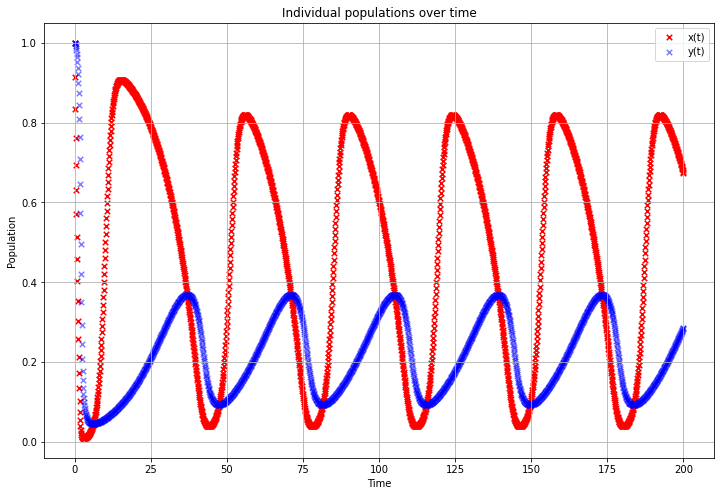

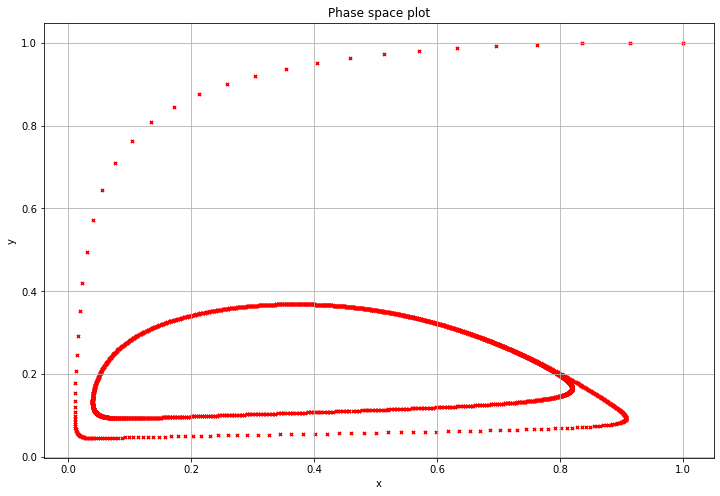

In [8]:
# Define ODE function f(x,t)
def predator_prey(params, x: np.ndarray, t: float):
    '''
    Defines RHS for Predator Prey system
    '''
    # Unpack constants
    a,d,b = params
    dxdt = x[0]*(1-x[0]) - (a*x[0]*x[1])/(d+x[0])
    dydt = b*x[1]*(1-(x[1]/x[0]))
    return np.array((dxdt, dydt))

# We plot a basic trajectory with b=0.1 to get an initial point and period guess
x_init = np.array((1,1))
solution = solve_to(predator_prey, [1,0.1,0.1], x_init, 0, 200, 0.1, 'RK4')

# Plotting x and y vs t, and x vs y phase plot
plt.figure(figsize=[12,8])
plt.scatter(solution[:,0], solution[:,1], c='r', marker='x', s=30, label='x(t)')
plt.scatter(solution[:,0], solution[:,2], c='b', marker='x', s=30,label='y(t)', alpha=0.5)
plt.legend()
plt.title("Individual populations over time")
plt.xlabel("Time")
plt.ylabel("Population")
plt.grid()
plt.show()
plt.figure(figsize=[12,8])
plt.scatter(solution[:,1], solution[:,2], c='r', marker='x', s=10)
plt.title("Phase space plot")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

We now plot the limit cycle period against the parameter $b$, using the natural parameter continuation method and pseudo arclength continuation method, starting from $b=0.1$ with an initial point and period guess informed by the graph above.

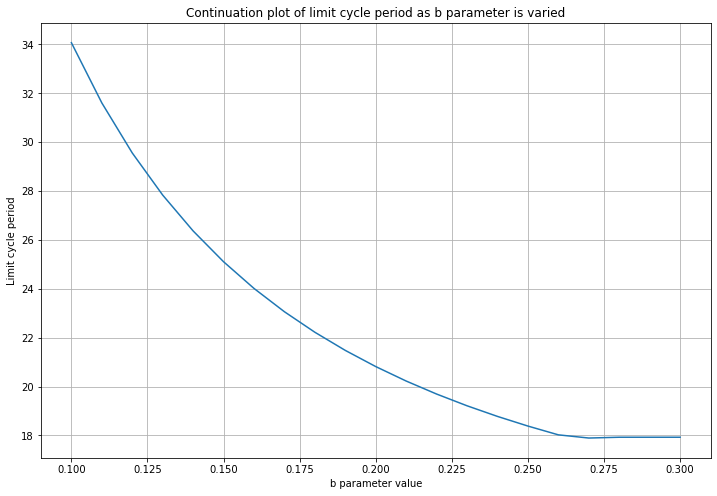

/var/folders/r2/3w7vkj3n6z5c55vp_fm676380000gn/T/ipykernel_24874/4110373743.py:8: RuntimeWarning: overflow encountered in scalar multiply
  dxdt = x[0]*(1-x[0]) - (a*x[0]*x[1])/(d+x[0])
/var/folders/r2/3w7vkj3n6z5c55vp_fm676380000gn/T/ipykernel_24874/4110373743.py:8: RuntimeWarning: invalid value encountered in scalar divide
  dxdt = x[0]*(1-x[0]) - (a*x[0]*x[1])/(d+x[0])


Numerical divergence encountered, terminating continuation
Numerical divergence encountered, terminating continuation
Numerical divergence encountered, terminating continuation


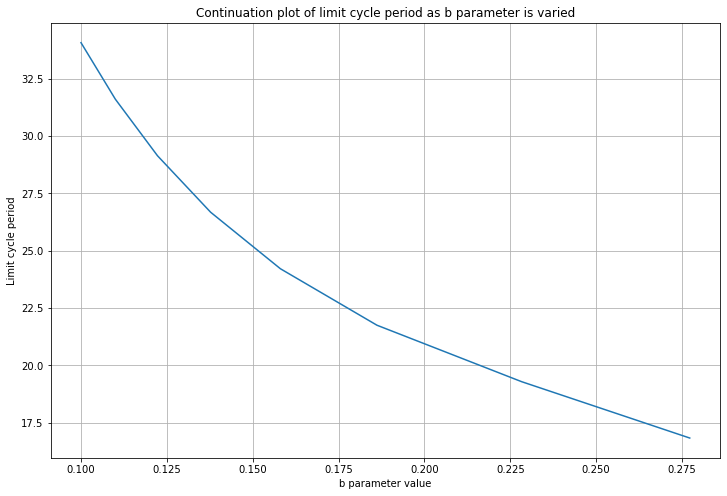

In [9]:
default_params=[1,0.1,0.1]
b_index = 2
b_start = 0.1
b_step = 0.01
init_point_guess = np.array(([0.8,0.2]))
init_period_guess = 30
num_steps = 20

pair_store, b_store = limit_cycle_continuation(predator_prey,
                                               default_params,
                                               b_index,b_start, b_step,
                                               init_point_guess, init_period_guess,
                                               num_steps, method='NPC')

plt.figure(figsize=[12,8])
plt.plot(b_store, pair_store[:,0])
plt.grid()
plt.xlabel("b parameter value")
plt.ylabel("Limit cycle period")
plt.title("Continuation plot of limit cycle period as b parameter is varied")
plt.show()

pair_store, b_store = limit_cycle_continuation(predator_prey,
                                               default_params,
                                               b_index,b_start, b_step,
                                               init_point_guess, init_period_guess,
                                               10, method='PAC')

plt.figure(figsize=[12,8])
plt.plot(b_store, pair_store[:,0])
plt.grid()
plt.xlabel("b parameter value")
plt.ylabel("Limit cycle period")
plt.title("Continuation plot of limit cycle period as b parameter is varied")
plt.show()

We find that the pseudo-arclength method comes across a fatal error near the point of bifurcation of $b=0.26$.

In the process of checking the pseudo-arclength continuation we find that there is a fundamental weakness in our code. Our `solve_to` method may predict a solution which diverges, and first predicts a value of `inf` for a variable, and for subsequent timesteps produces `nan`. The `uT` calculated in each `limit_cycle_condition` call when working out `G=uT-u0` then may contain a `nan` value, and the whole function crashes.

We introduce a `try, except` clause at each step, which tries to calculate the next point along a numerical continuation, but if unsuccessful then prints that we've run into a problem and terminates the continuation, but still returns the continuation we have found up to that point.

----------------
Finally we produce a 3D plot where each `b` value on the x axis has a corresponding plotted orbit with the given starting conditions on the `x` and `y` axes


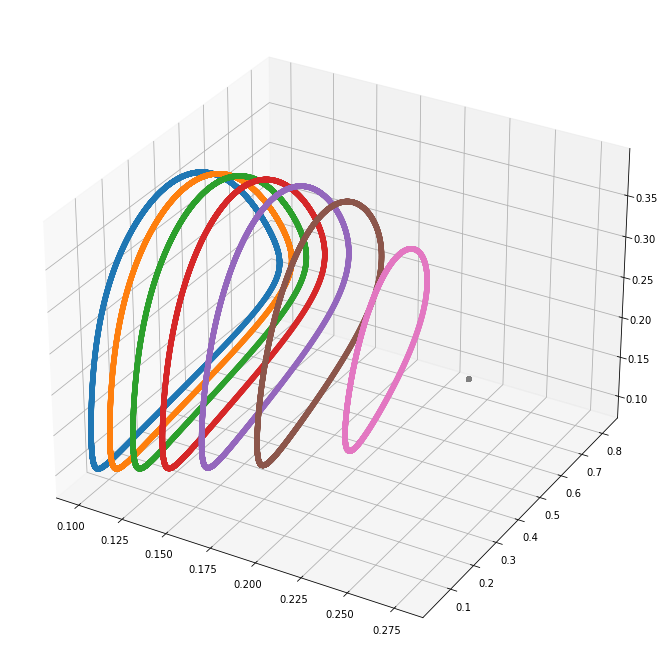

In [14]:
fig = plt.figure(figsize = (12,12))
ax = plt.axes(projection='3d')
params = default_params
for index, b in enumerate(b_store):
    params[b_index]=b
    init_point = pair_store[index,1:]
    period = pair_store[index,0]
    store = solve_to(predator_prey,params,init_point,0,2*period,0.01)
    yvals = store[:,1]
    zvals = store[:,2]
    xvals = b*np.ones([len(yvals)])
    ax.scatter(xvals,yvals,zvals)
plt.show()